In [1]:
# %% 

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import mediapipe as mp
from tqdm import tqdm
import math


# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# %% markdown
# ## 2. Data Preparation
# %% 

# Define paths to your dataset - UPDATE THESE PATHS TO YOUR ACTUAL DIRECTORIES
correct_exercise_dir = "./OneDrive/Desktop/tricep-pushdown_dataset/correct"  # Directory containing correct form videos
incorrect_exercise_dir = "./OneDrive/Desktop/tricep-pushdown_dataset/incorrect"  # Directory containing incorrect form videos

# %% markdown
# ### 2.1 Video Processing Functions
# %% 

def extract_frames(video_path, max_frames=30):
    """Extract frames from video and resize to consistent dimensions"""
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0

    while cap.isOpened() and frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        # Resize frame to consistent dimensions
        frame = cv2.resize(frame, (640, 480))
        frames.append(frame)
        frame_count += 1

    cap.release()
    return frames

def extract_landmarks(frames):
    """Extract pose landmarks from frames using MediaPipe"""
    landmarks_sequence = []

    for frame in frames:
        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Process the frame
        results = pose.process(frame_rgb)
        
        if results.pose_landmarks:
            # Extract all 33 landmarks (x,y,z,visibility)
            frame_landmarks = []
            for landmark in results.pose_landmarks.landmark:
                frame_landmarks.extend([landmark.x, landmark.y, landmark.z, landmark.visibility])
            landmarks_sequence.append(frame_landmarks)
        else:
            # If no landmarks detected, add zeros
            landmarks_sequence.append([0]*132)  # 33 landmarks * 4 values

    return landmarks_sequence

In [2]:
# %% markdown
# Process all videos and create dataset
def create_dataset(video_dir, label, max_videos=None, max_frames=30):
    """Create dataset from directory of videos"""
    X = []
    y = []
    video_files = [f for f in os.listdir(video_dir) if f.endswith(('.mp4', '.avi', '.mov'))]

    if max_videos:
        video_files = video_files[:max_videos]

    for video_file in tqdm(video_files, desc=f"Processing {label} videos"):
        video_path = os.path.join(video_dir, video_file)
        try:
            frames = extract_frames(video_path, max_frames)
            landmarks_sequence = extract_landmarks(frames)
            
            # Pad or truncate sequence to max_frames
            if len(landmarks_sequence) < max_frames:
                # Pad with zeros
                pad_length = max_frames - len(landmarks_sequence)
                landmarks_sequence += [[0]*132 for _ in range(pad_length)]
            elif len(landmarks_sequence) > max_frames:
                # Truncate
                landmarks_sequence = landmarks_sequence[:max_frames]
            
            X.append(landmarks_sequence)
            y.append(label)
        except Exception as e:
            print(f"Error processing {video_file}: {str(e)}")
            continue

    return np.array(X), np.array(y)

# %% markdown
# ### 2.2 Feature Engineering: Calculate Joint Angles
# %% 

def calculate_angle(a, b, c):
    """Calculate the angle between three points"""
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)

    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)

    if angle > 180.0:
        angle = 360 - angle
    
    return angle

def extract_angles_from_landmarks(landmarks_sequence):
    """Extract joint angles from landmarks sequence"""
    angle_sequences = []

    for frame_landmarks in landmarks_sequence:
        # Reshape to 33x4 (landmarks x (x,y,z,visibility))
        landmarks = np.array(frame_landmarks).reshape(33, 4)
        
        # Get relevant landmarks (using MediaPipe indices)
        # Shoulder, elbow, wrist for arm angles
        left_shoulder = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value][:2]
        left_elbow = landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value][:2]
        left_wrist = landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value][:2]
        
        right_shoulder = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value][:2]
        right_elbow = landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value][:2]
        right_wrist = landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value][:2]
        
        # Hip, shoulder, elbow for torso angles
        left_hip = landmarks[mp_pose.PoseLandmark.LEFT_HIP.value][:2]
        right_hip = landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value][:2]
        
        # Calculate angles (handle cases where landmarks might be missing)
        angles = []
        try:
            left_arm_angle = calculate_angle(left_shoulder, left_elbow, left_wrist)
            angles.append(left_arm_angle)
        except:
            angles.append(0)
        
        try:
            right_arm_angle = calculate_angle(right_shoulder, right_elbow, right_wrist)
            angles.append(right_arm_angle)
        except:
            angles.append(0)
        
        try:
            left_torso_angle = calculate_angle(left_hip, left_shoulder, left_elbow)
            angles.append(left_torso_angle)
        except:
            angles.append(0)
        
        try:
            right_torso_angle = calculate_angle(right_hip, right_shoulder, right_elbow)
            angles.append(right_torso_angle)
        except:
            angles.append(0)
        
        angle_sequences.append(angles)

    return np.array(angle_sequences)

In [3]:
# %% markdown
# Load and process real data
print("Loading correct exercise videos...")
X_correct, y_correct = create_dataset(correct_exercise_dir, label=1)

print("\nLoading incorrect exercise videos...")
X_incorrect, y_incorrect = create_dataset(incorrect_exercise_dir, label=0)

# Check if we have data
if len(X_correct) == 0 or len(X_incorrect) == 0:
    raise ValueError("No videos found in the specified directories. Please check your paths.")

# Combine datasets
X = np.concatenate((X_correct, X_incorrect))
y = np.concatenate((y_correct, y_incorrect))

# Extract angles for all sequences
print("\nExtracting joint angles...")
X_angles = np.array([extract_angles_from_landmarks(seq) for seq in tqdm(X)])

# Combine raw landmarks and angles
X_combined = np.concatenate([X, X_angles], axis=-1)


Loading correct exercise videos...


Processing 1 videos:   0%|          | 0/54 [00:00<?, ?it/s]C:\Users\sthel\AppData\Roaming\Python\Python311\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Processing 1 videos: 100%|██████████| 54/54 [01:37<00:00,  1.81s/it]



Loading incorrect exercise videos...


Processing 0 videos: 100%|██████████| 63/63 [01:53<00:00,  1.81s/it]



Extracting joint angles...


100%|██████████| 117/117 [00:00<00:00, 1103.45it/s]


In [4]:
# %% markdown
# ### 2.3 Train-Test Split
# %% 

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y)

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# %% markdown
# ## 3. LSTM Model
# %% 

def create_lstm_model(input_shape):
    """Create LSTM model for posture classification"""
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(2, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model


Training samples: 93
Test samples: 24


In [5]:
# Create and train model
input_shape = (X_train.shape[1], X_train.shape[2])
model = create_lstm_model(input_shape)

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    X_train, y_train_cat,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test_cat),
    callbacks=[early_stop])

# %% markdown
# ## 4. Model Evaluation
# %% 

C:\Users\sthel\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accuracy: 0.4763 - loss: 0.7193 - val_accuracy: 0.6667 - val_loss: 0.6577
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6971 - loss: 0.6231 - val_accuracy: 0.8750 - val_loss: 0.6143
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8271 - loss: 0.6044 - val_accuracy: 0.8333 - val_loss: 0.5893
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8310 - loss: 0.5457 - val_accuracy: 0.8333 - val_loss: 0.5649
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8901 - loss: 0.5068 - val_accuracy: 0.8750 - val_loss: 0.5301
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9296 - loss: 0.4645 - val_accuracy: 0.8750 - val_loss: 0.4971
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9233 - loss: 0.4244 - val_accuracy: 0.8750 - val_loss: 0.4643
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9140 - loss: 0.3727 - val_accuracy: 0.8750 - val_loss: 0.4433

In [6]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8750 - loss: 0.4284
Test Accuracy: 87.50%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


In [7]:
# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("\nConfusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))



Confusion Matrix:
[[13  0]
 [ 3  8]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90        13
           1       1.00      0.73      0.84        11

    accuracy                           0.88        24
   macro avg       0.91      0.86      0.87        24
weighted avg       0.90      0.88      0.87        24



Text(0.5, 1.0, 'Model Loss')

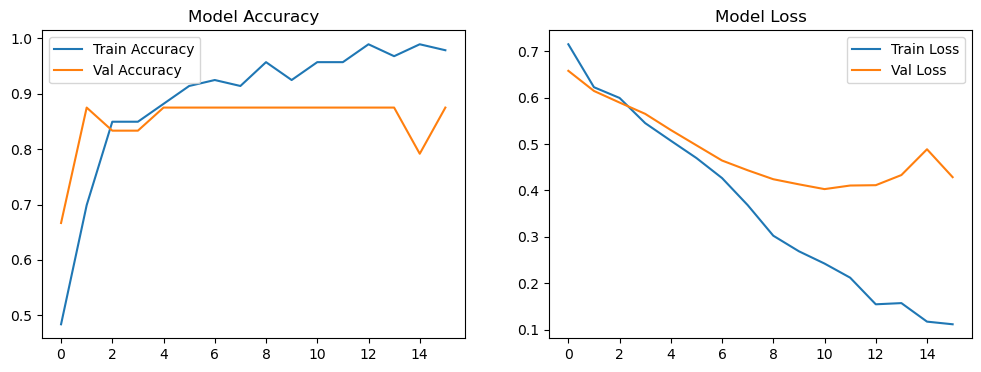

In [8]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')

Confusion Matrix:
 [[13  0]
 [ 3  8]]


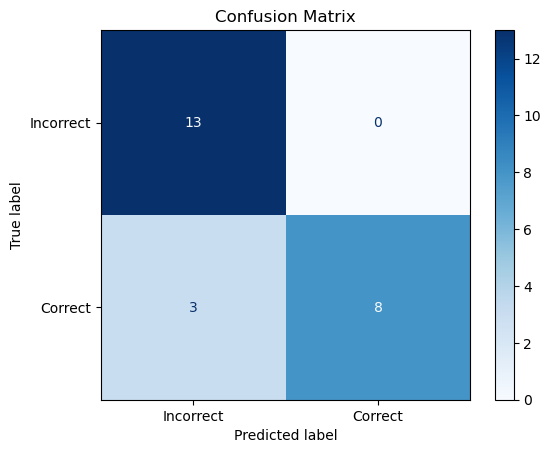

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Incorrect", "Correct"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [10]:
from sklearn.metrics import roc_curve, auc

# Get probabilities for positive class (correct form = class 1)
y_score = y_pred_proba[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


NameError: name 'y_pred_proba' is not defined

In [11]:
class OverheadExerciseAnalyzer:
    def __init__(self, model):
        self.model = model
        self.rep_count = 0
        self.correct_posture = False

    def analyze_frame(self, frame):
        """Analyze the posture in a single frame"""
        landmarks_sequence = extract_landmarks([frame])
        angles = extract_angles_from_landmarks(landmarks_sequence)

        # Predict posture
        X = np.concatenate([landmarks_sequence, angles], axis=-1)
        X = np.expand_dims(X, axis=0)  # Add batch dimension

        y_pred = self.model.predict(X)
        posture_class = np.argmax(y_pred, axis=1)

        # Count reps (based on arm angles)
        arm_angle = angles[0][0]  # Left arm angle (example)

        if arm_angle < 45 and not self.correct_posture:
            self.rep_count += 1
            self.correct_posture = True
        elif arm_angle > 160:
            self.correct_posture = False

        return posture_class

    def run_real_time_analysis(self, video_source=0):
        """Run real-time analysis on video feed"""
        cap = cv2.VideoCapture(video_source)

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            posture_class = self.analyze_frame(frame)

            # Annotate frame
            label = "Correct" if posture_class == 1 else "Incorrect"
            color = (0, 255, 0) if posture_class == 1 else (0, 0, 255)

            cv2.putText(frame, f"{label}", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 2)
            cv2.putText(frame, f"Reps: {self.rep_count}", (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 0), 2)

            # Show frame
            cv2.imshow("Posture Analysis", frame)

            # Break on 'q' key
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()

# Initialize and run
analyzer = OverheadExerciseAnalyzer(model)
analyzer.run_real_time_analysis()


C:\Users\sthel\AppData\Roaming\Python\Python311\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━